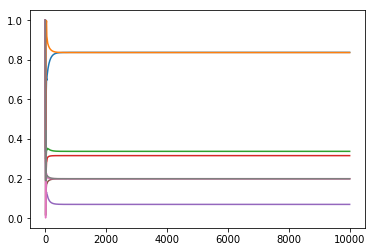

Zum Testen


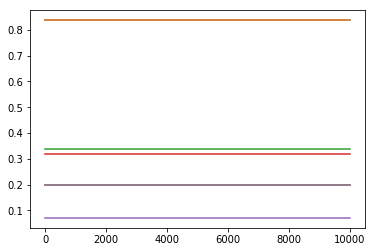

So viele haben vor der Invasion überlebt: 5
[0.83768367 0.8369873  0.33820655 0.31663881 0.07048366 0.19999999
 0.2        0.20000001]
1
-----------------------------------------------------------------------
3.0001400000000045
2
-----------------------------------------------------------------------
2.9998099999999988
3
-----------------------------------------------------------------------
2.9991800000000364
4
-----------------------------------------------------------------------
3.000090000000039
5
-----------------------------------------------------------------------
3.000089999999997
Pro Simulation haben mit dem/ den Invader/n überlebt (0 bedeutet, dass keiner verstorben ist): [0, 0, 0, 0, 0]
(1008,)


In [3]:
###############################################################
import time
start = time.time()
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import ode
#from scipy.linalg import norm
from numpy.linalg import norm
from functools import partial
np.set_printoptions(suppress=True)
%matplotlib inline   

def create_parameter (number_species, number_resources):
    
    """ Funktion soll am Ende ein Dictionary bekommen, welches zufällige Werte beinhaltet, die zu den jeweiligen Parametern zugeordnet sind. 
    Die Anzahl der Werte der jeweiligen Parametern wird durch die Eingabe 'number_resources' und 'number_species' bestimmt. Im Gegensatz zu der Funktion
    'get_parameters' beinhaltet diese Funktion auch die Matrix a, die mit Zufallswerte gefüllt ist."""
    
    parameter_dict={}
    liste_parameter = []
    for i in ["w","r","K"]:
        parameter_dict[i] = np.repeat(1,number_resources)
            
    parameter_dict["T"] = np.repeat(0.2,number_species)
    parameter_dict["c"] = np.repeat(1,number_species)
    
    parameter_dict["number_species"] = len(parameter_dict["c"])
    parameter_dict["number_resources"] = len(parameter_dict["w"])
    
    a = np.random.rand(number_species,number_resources)
    a = a/a.sum(axis=1,keepdims=1)
    
    parameter_dict["a"] = a   
    
    return parameter_dict
    
class MacArther_C_R_2():    # zum Testen für steady-state -> timecourse fehlt
   
    def __init__(self, dict_parameter): #when using the function the first time it asks for parameters
        self.dict_parameter = dict_parameter
        self.p = self.dict_parameter.copy()
        self.number_species = dict_parameter["number_species"]
        self.number_resources = dict_parameter["number_resources"]
        self.T = dict_parameter["T"]
        self.c = dict_parameter["c"]
        self.w = dict_parameter["w"]
        self.r = dict_parameter["r"]
        self.K = dict_parameter["K"]
        self.a = dict_parameter["a"]
        

    #h function
    def h(self, R):
        h = self.r * R / self.K * (self.K - R)
        return h

    #model
    def mcr(self, t,y):        
        X = y[:self.number_species]                            
        R = y[self.number_species:]
        dXdt = self.c*X*(np.sum(self.w*self.a*R,axis=1) - self.T)
        dRdt = self.h(R) - (self.a*R).T.dot(X)
        output = np.concatenate((dXdt,dRdt),axis=None)
        return output
    
    
    def timecourse(self, y, t):
        integ = ode(self.mcr).set_integrator('lsoda').set_initial_value(y,0)            
        cnt = 1
        sol = [y]
        while cnt < len(t):
            sol.append(integ.integrate(t[cnt]))
            cnt += 1
        return np.array(sol)
    
    
    def steadystate(self,y, tmax = 10000000000, threshold=1e-9):                   # Anfangs 1e-9, aber threshold war zu niedrig, sodass kein steady-state errechnet werden konnte. Wenn Threshold zu niedrig ist, dann sind da zu viele Werte
        integ = ode(self.mcr).set_integrator('lsoda').set_initial_value(y,0)    
        ss = y
        t = range(tmax)
        cnt = 1
        while cnt < len(t):
            #print(cnt)
            ss_new = integ.integrate(t[cnt])
            if norm(ss-ss_new) < threshold:
                return ss_new
            else:
                ss = ss_new
                cnt += 1
   
    
class Mit_Invader():
    
    def __init__ (self, MacArthur, y0, anfangswert = 1, anzahl = 1):
        self.dict_parameter = MacArthur
        self.number_species = MacArthur.number_species 
        self.number_resources = MacArthur.number_resources
        self.T = MacArthur.T
        self.c = MacArthur.c
        self.w = MacArthur.w
        self.r = MacArthur.r
        self.K = MacArthur.K
        self.a = MacArthur.a
        self.y0 = y0
        
        def expand_system (self, anzahl, anfangswert):
            X0 = self.y0[:self.number_species]
            R0 = self.y0[self.number_species:]

            for i in (range(anzahl)):

                self.T = np.append(self.T,0.2)
                self.c = np.append(self.c,1)
                g = np.random.rand( 1 , self.number_resources)
                g = g/g.sum(axis=1,keepdims=1)
                self.a = np.append(self.a,g,0)
                X0 = np.append(X0,anfangswert)
                self.number_species += 1
             
            self.y0 = np.concatenate((X0,R0),axis=None)

            return self.y0
            
        expand_system(self, anzahl, anfangswert)
 
    #h function
    def h(self, R):
        h = self.r * R / self.K * (self.K - R)
        return h

    #model
    def mcr(self, t, y):        
        X = y[:self.number_species]
        R = y[self.number_species:]
        dXdt = self.c*X*(np.sum(self.w*self.a*R,axis=1) - self.T)
        dRdt = self.h(R) - (self.a*R).T.dot(X)
        output = np.concatenate((dXdt,dRdt),axis=None)
        return output
    
    
    def timecourse(self, y, t):
        integ = ode(self.mcr).set_integrator('lsoda').set_initial_value(y,0)            
        cnt = 1
        sol = [y]
        while cnt < len(t):
            sol.append(integ.integrate(t[cnt]))
            cnt += 1
        return np.array(sol)
    
    def steadystate(self,x0, toleranz=1e-9):
        results0 = [x0]
        time=range(1000000000)
        error = np.linalg.norm(results0[0],ord=2)
        integrator = ode(self.mcr).set_integrator('lsoda').set_initial_value(x0,0)
        cnt=1
        while cnt < len(time) and error > toleranz and integrator.successful:
            zahl = integrator.integrate(time[cnt])
            error=np.linalg.norm(zahl-results0[-1],ord=2)
            results0.append(zahl) 
            cnt += 1
        return np.round(results0[-1],decimals=5)
    
    
    def fitness (self):
        X = self.y0[:self.number_species]
        R = self.y0[self.number_species:]
        dXdt = self.c*X*(np.sum(self.w*self.a*R,axis=1) - self.T)

        return dXdt

p_dict = create_parameter(5,3)
t = np.linspace(0,10000,1000)
wieviele_invader = 1
graphengroesse = (8, 4)

Task3 = MacArther_C_R_2(p_dict)   # Viele Spezies und Ressourcen klappen nicht -> NoneType kommt raus => Um das zu beheben, muss Threshold in steadystate aus Klasse Task3 vergrößert werden
                                         
R0 = np.repeat(1,Task3.number_resources)
X0 = np.repeat(1,Task3.number_species)
y0 = np.concatenate((X0,R0),axis=None)

plt.plot(t,Task3.timecourse(y0,t))
plt.show()
print("Zum Testen")
k = Task3.steadystate(y0)
plt.plot(t,Task3.timecourse(k,t))
plt.show()

#plt.plot(t,Task3.timecourse(k,t))

wie_oft = 5


def ueberlebt(fitness, threshold=1e-3):
    cnt = sum(fitness > threshold)
    return cnt

#def gestorben(fitness)

wie_viele_pro_simulation_ueberlebt = []

print("So viele haben vor der Invasion überlebt:",ueberlebt(k[:Task3.number_species]))
print(k)
for i in range (wie_oft):
    print(i+1)
    try:
        Invader = Mit_Invader(Task3, y0 = k, anfangswert = 0.002, anzahl = wieviele_invader)
        
        steadystate_with_Invader = Invader.steadystate(Invader.y0)

        print('-----------------------------------------------------------------------')
        print(sum(steadystate_with_Invader))
        if sum(steadystate_with_Invader[:31]) < 1e-6:
            pass
        else:
            wie_viele_pro_simulation_ueberlebt.append(ueberlebt(steadystate_with_Invader[:Task3.number_species])-ueberlebt(k[:Task3.number_species]))        
    except:
        pass

print("Pro Simulation haben mit dem/ den Invader/n überlebt (0 bedeutet, dass keiner verstorben ist):",wie_viele_pro_simulation_ueberlebt)
print(steadystate_with_Invader.shape)

In [11]:
def gestorben(fitness, threshold=1e-3):
    cnt = sum(fitness < threshold)
    return cnt

print(ueberlebt(k[:Task3.number_species]))
print(k[:Task3.number_species])
print(gestorben(k[:Task3.number_species]))

ü = 0
for i in k[:Task3.number_species]:
    ü += i
ü = ü/ len(k[:Task3.number_species])
print(ü)

print("mean",np.mean(k[:Task3.number_species]))
print(np.median(k[:Task3.number_species]))

#print(Invader.timecourse(Invader.y0,t)[:,30])
# f = 1e-6
# print(f)
# print(-1 > 0)
# test = sum(steadystate_with_Invader[:30] > f) - sum(k[:30] > f)
# print(test)
# print(ueberlebt(steadystate_with_Invader[:Task3.number_species]))
# print(ueberlebt(k[:Task3.number_species]))
# print()
# print(ueberlebt(steadystate_with_Invader[:Task3.number_species]) - ueberlebt(k[:Task3.number_species]))
# print(sum(k))
# print(sum(k[:30]))
# print()
# print(k)
# print()
# print(sum(steadystate_with_Invader))
# print(sum(steadystate_with_Invader[:31]))
# print()
# print(steadystate_with_Invader[:31])
# print()
# print(steadystate_with_Invader)

5
[0.23609125 0.39412046 0.59437723 0.12720149 1.04820958]
0
0.48000000000025844
mean 0.48000000000025844
0.3941204581818619


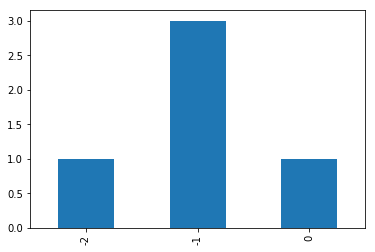

In [44]:
import pandas as pd
pd.Series(wie_viele_pro_simulation_ueberlebt).value_counts().sort_index().plot(kind='bar')

In [1]:
def create_parameter (number_species, number_resources):
    
    """ Funktion soll am Ende ein Dictionary bekommen, welches zufällige Werte beinhaltet, die zu den jeweiligen Parametern zugeordnet sind. 
    Die Anzahl der Werte der jeweiligen Parametern wird durch die Eingabe 'number_resources' und 'number_species' bestimmt. Im Gegensatz zu der Funktion
    'get_parameters' beinhaltet diese Funktion auch die Matrix a, die mit Zufallswerte gefüllt ist."""
    
    parameter_dict={}
    liste_parameter = []
    for i in ["w","r","K"]:
        parameter_dict[i] = np.repeat(1,number_resources)
            
    parameter_dict["T"] = np.repeat(0.2,number_species)
    parameter_dict["c"] = np.repeat(1,number_species)
    
    parameter_dict["number_species"] = len(parameter_dict["c"])
    parameter_dict["number_resources"] = len(parameter_dict["w"])
    
    a = np.random.rand(number_species,number_resources)
    a = a/a.sum(axis=1,keepdims=1)
    
    parameter_dict["a"] = a   
    
    return parameter_dict

p_dict = create_parameter(40,30)

NameError: name 'np' is not defined

In [8]:
sum(steadystate_with_Invader[:31]) 

31.846959999999996

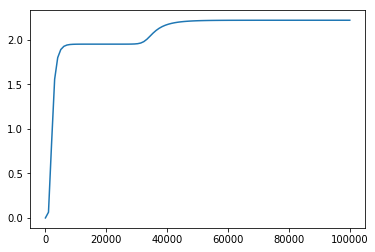

In [9]:
t = np.linspace(0,100000,100)
plt.plot(t,Invader.timecourse(Invader.y0,t)[:,30])

In [10]:
np.where(k[:30]>1e-3)

(array([ 0,  1,  2,  3,  4,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16, 17, 18,
        19, 20, 21, 22, 23, 25, 26], dtype=int64),)

In [11]:
np.where(steadystate_with_Invader[:31]>1e-3)

(array([ 0,  1,  3,  4,  6,  7,  8, 10, 11, 13, 14, 16, 17, 18, 19, 20, 21,
        22, 23, 25, 26, 30], dtype=int64),)

In [12]:
steadystate_with_Invader[:31]

array([ 1.20702,  2.63122,  0.     ,  0.38382,  1.27869,  0.     ,
        0.61282,  1.06355,  1.24146,  0.     ,  1.99382,  1.77394,
        0.     ,  0.99352,  2.10422,  0.     ,  0.31126,  1.19402,
        1.59073,  2.40201,  1.09462,  0.49119,  2.68624,  1.3591 ,
        0.     ,  1.43166,  2.04333, -0.     , -0.     ,  0.     ,
        1.94979])

In [13]:
len(wie_viele_pro_simulation_ueberlebt)

5

# Aufgaben von der Besprechung:

## Aufgabe 3.1: 
a-Matrix bleibt gleich und alle anderen Parameter werden verändert. Zunächst mit einer Spezies und mit einer Ressource, dann mit mehreren Spezies und mehreren Ressourcen.

Auch sollen die Umformungen der Formel getestet werden.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import ode
from numpy.linalg import norm
from functools import partial
%matplotlib inline   

# ns = np.random.random_integers(1,5)
# nr = np.random.random_integers(1,3)
# print(ns, nr)
number_species = 2
number_resources = 1
a = np.random.rand(number_species,number_resources)
a = a/a.sum(axis=1,keepdims=1)
print(a)

[[1.]
 [1.]]


In [3]:
a = np.array([[0.72661522, 0.27338478], 
               [0.54409918, 0.45590082]])
print(a)

[[0.72661522 0.27338478]
 [0.54409918 0.45590082]]


In [7]:
a = np.array([[1],[0.5]])
a

array([[1. ],
       [0.5]])

1
Steadystate für R: [0.2] 
Steadystate für X: [0.38889 0.38889]


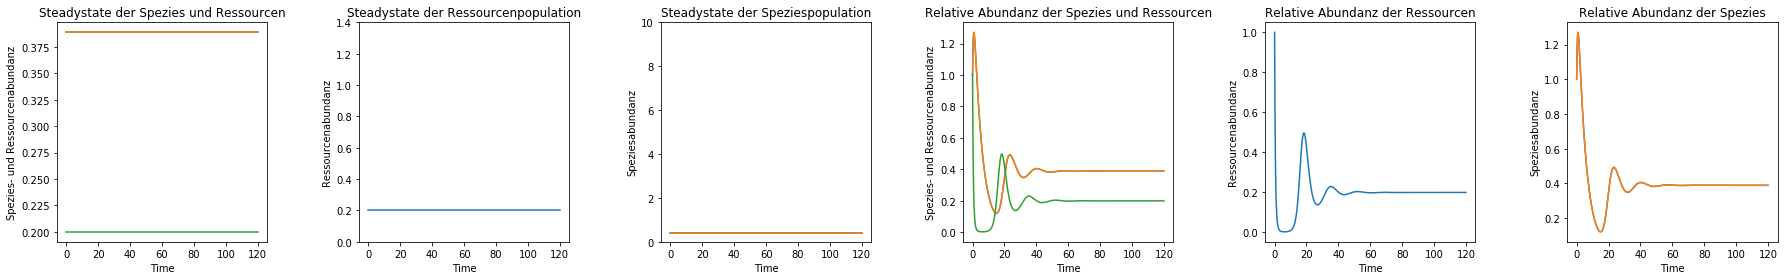

2
Steadystate für R: [0.2] 
Steadystate für X: [0.88889 0.88889]


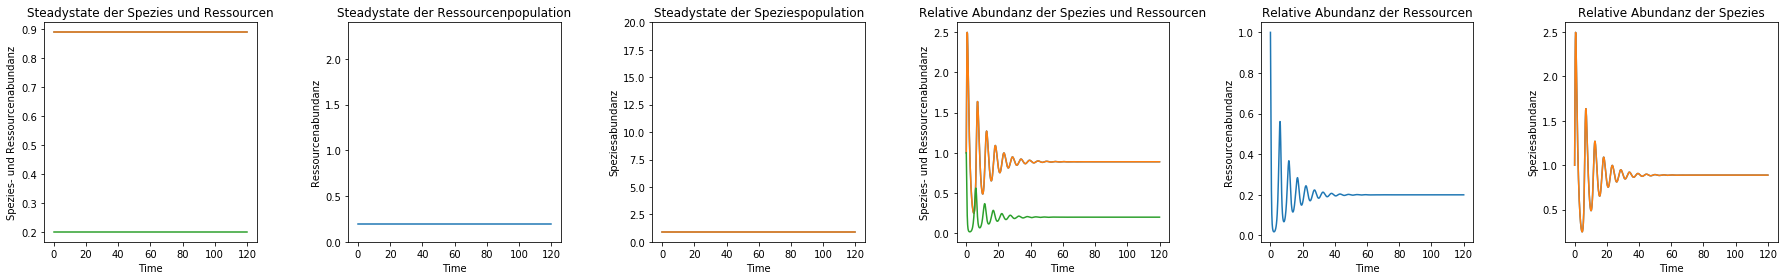

3
Steadystate für R: [0.2] 
Steadystate für X: [1.38889 1.38889]


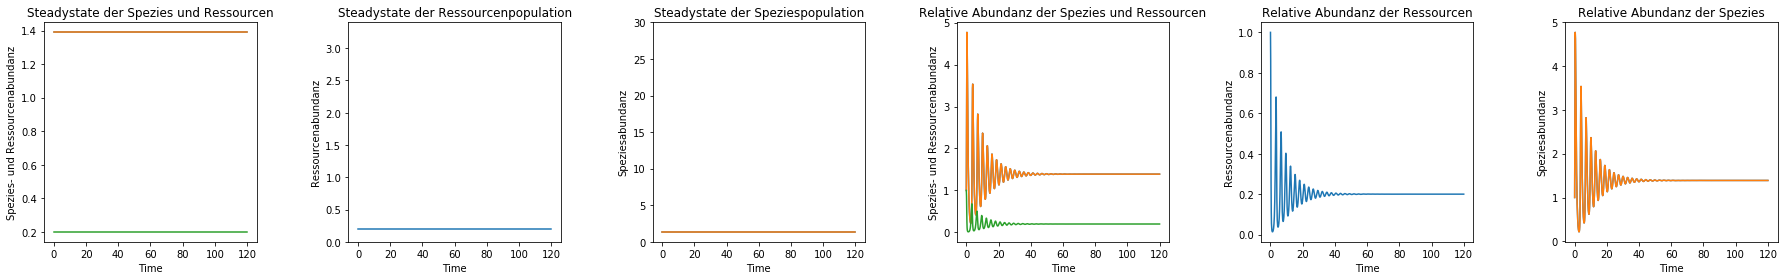

4
Steadystate für R: [0.2] 
Steadystate für X: [1.88889 1.88889]


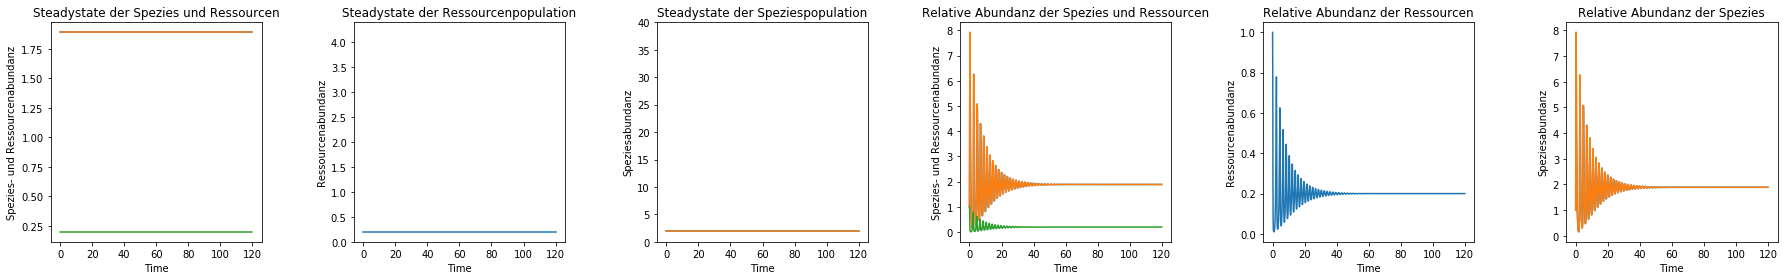

5
Steadystate für R: [0.2] 
Steadystate für X: [2.38889 2.38889]


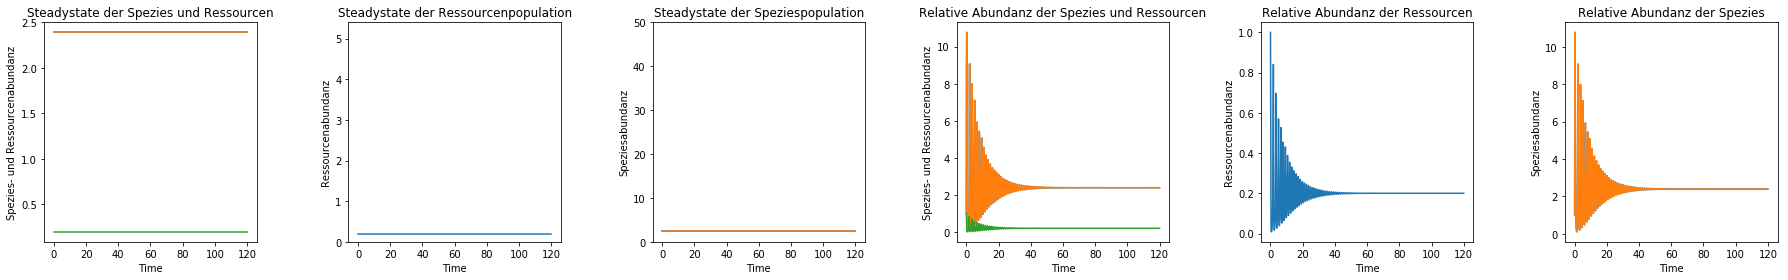

In [10]:
RS_und_XS = []

def h(R):
    h = r*R/K * (K - R)
    return h

def mcr(t,y,w,c,r,K,T,a):
    X = y[:number_species]
    R = y[number_species:]
    #print("c, X, w, a, R, T")
    #print(y)
    dXdt = c*X*(np.sum(w*a*R,axis=1) - T)
    dRdt = h(R) - (a*R).T.dot(X)
    output = np.concatenate((dXdt,dRdt),axis=None)
    return output

def timecourse(sys, y, t):
    integ = ode(sys).set_integrator('lsoda').set_initial_value(y,0)
    cnt = 1
    sol = [y]
    while cnt < len(t):
        sol.append(integ.integrate(t[cnt]))
        cnt += 1
    return np.array(sol)

def steadystate(system, x0,toleranz=1e-9):
    results0 = [x0]
    time=range(1000000000)
    error = np.linalg.norm(results0[0],ord=2)
    integrator = ode(system).set_integrator('lsoda').set_initial_value(x0,0)
    cnt=1
    while cnt < len(time) and error > toleranz and integrator.successful:
        zahl = integrator.integrate(time[cnt])
        error=np.linalg.norm(zahl-results0[-1],ord=2)
        results0.append(zahl) 
        cnt += 1
    return np.round(results0[-1],decimals=5)


def R_steadystate(T,w,a):    # für 1-dimensionalen Fall
    R = T / (w * a)

    return R

def X_steadystate(r,a,T,w,K):                 # für 1-dimensionalen Fall
    X = (r/a) * (1 - T / (w * a * K))

    return X

for i in range (1, 6):

    print(i)
    w = np.repeat(i,number_resources)  
    r = np.repeat(i,number_resources)  
    K = np.repeat(i,number_resources) 
    
    T = np.repeat((i/5),number_species)  
    c = np.repeat(i,number_species)
    
    R0 = np.repeat(1,number_resources)
    X0 = np.repeat(1,number_species)
    y0 = np.concatenate((X0,R0),axis=None)
    t = np.linspace(0,120,1000)

    system = partial(mcr, w=w, c=c, r=r, K=K, T=T, a=a)
    

    sol0 = timecourse(system, y0, t)
    sol1 = steadystate(system, y0)
    sol2 = timecourse(system, sol1, t)
    
    if number_species == 1 and number_resources == 1:
        #RS = partial(R_steadystate,T=T, w=w, a=a)
        print("Steadystate für R:",R_steadystate(T,w,a))
        #XS = partial(X_steadystate, r=r, a=a, T=T, w=w, K=K)
        print("Steadystate für X:",X_steadystate(r,a,T,w,K))

    else:
        print("Steadystate für R:",sol1[number_species:], "\nSteadystate für X:", sol1[:number_species])   

    
#     if number_species == 1:
#         eine_spezies_eine_ressource.append([RS, XS])
#     else:
#         mehrere_spezies_mehrere_ressourcen.append([RS, XS])
    
    #RS_und_XS.append([sol1[number_species:], sol1[:number_species]])
    
    graphengroesse = (25, 4)

    fig, axes = plt.subplots(nrows=1, ncols=6, figsize=graphengroesse)
    
    #plt.suptitle('Wenn man keine Parameter ändert') 
    #plt.suptitle('Wenn man den Parameter w verdoppelt') 
    #plt.title("Test")
    axes[0].plot(t,sol2)
    axes[1].plot(t,sol2[:,number_species:])
    axes[1].set_ylim(0, i + 0.4)
    axes[2].plot(t,sol2[:,:number_species])
    axes[2].set_ylim(0, i * 10)  #sol1[:number_species][1]

    axes[3].plot(t,sol0)
    axes[4].plot(t,sol0[:,number_species:])
    #axes[4].set_ylim(0, i + 0.4)
    axes[5].plot(t,sol0[:,:number_species])
    #axes[5].set_ylim(0, i * 10)    
    

    axes[0].set_title("Steadystate der Spezies und Ressourcen")
    axes[0].set(xlabel='Time', ylabel='Spezies- und Ressourcenabundanz')
    
    axes[1].set_title("Steadystate der Ressourcenpopulation")
    axes[1].set(xlabel='Time', ylabel='Ressourcenabundanz')
    
    axes[2].set_title("Steadystate der Speziespopulation")
    axes[2].set(xlabel="Time", ylabel="Speziesabundanz")
    
    axes[3].set_title("Relative Abundanz der Spezies und Ressourcen")
    axes[3].set(xlabel='Time', ylabel='Spezies- und Ressourcenabundanz')
    
    axes[4].set_title("Relative Abundanz der Ressourcen")
    axes[4].set(xlabel='Time', ylabel='Ressourcenabundanz')
    
    axes[5].set_title("Relative Abundanz der Spezies")
    axes[5].set(xlabel="Time", ylabel="Speziesabundanz")
    fig.tight_layout()
   
    #plt.savefig(f'C:/Users/Baklava/Desktop/Ergebnisse für BA/Matrix a ist fest, Parameter ändern sich/2 Spezies, 2 Ressourcen/c geändert/mal 1000/Steadystate für R {sol1[number_species:]}, Steadystate für X {sol1[:number_species]}.png', dpi=300, bbox_inches='tight')
    plt.show()
#mal 1000/
# timecourse mithinzufügen

# bei w und K braucht Programm länger für den Prozess

# lim um Graphen zu begrenzen?

# normierung bei 1 ressource und mehreren spezies weglassen

# anzahl der spezies gegen anzahl der ressourcen -> phasendiagramm

# phasendiagramm

# spezies 2, ressource 1  r parameter mal 1000  Steadystate der Speziespopulation  -> es gibt Fehler im 3. Plot, wenn ich Limit entferne

# spezies 2, ressource 1  T parameter mal 1000 -> mal nimmt Wachstum ab, mal steigt es




# von jupyter notebook zu python in Anaconda prompt "jupyter nbconvert --to script MacArthurModel.ipynb"

# überlebende (im steadystate) gegen shannon entropie

# zufallswerte, um spezialisten zu erhalten

# Fokus erst auf normale MacArthur Modell -> Cross-Feeding


# von Kapitel 2 bis 3.2 etwas hinzugefügt haben

In [40]:
#print(eine_spezies_eine_ressource)
#print(mehrere_spezies_mehrere_ressourcen)
# for i in mehrere_spezies_mehrere_ressourcen:
#     print (i)

for i in RS_und_XS:
    print("Steadystate von R:",i[0]," und Steadystate von X:",i[1])

Steadystate von R: [0.2]  und Steadystate von X: [0.8]
Steadystate von R: [0.2]  und Steadystate von X: [1.8]
Steadystate von R: [0.2]  und Steadystate von X: [2.8]
Steadystate von R: [0.2]  und Steadystate von X: [3.8]
Steadystate von R: [0.2]  und Steadystate von X: [4.8]


In [20]:
def unsinn_R (T,w,a,K):
    R = (T / ((w * a).T)).T
    #print(R)
    return R
print(unsinn_R(T=T,w=w,a=a,K=K))

[[0.2]]


## Aufgabe 3.2:
Das Gleiche wie in 3.1, aber dieses Mal sind die Parameter unveränderlich, während nur a-Matrix sich ändern soll

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import ode
from numpy.linalg import norm
from functools import partial
%matplotlib inline   

ns = np.random.random_integers(1,5)
nr = np.random.random_integers(1,3)
print(ns, nr)
number_species = 2
number_resources = 2

w = np.repeat(1,number_resources)
r = np.repeat(1,number_resources)
K = np.repeat(1,number_resources)

T = np.repeat((1/5),number_species)
c = np.repeat(1,number_species)

4 1


D:\Benutzer2\ZZZ\Programme\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: This function is deprecated. Please call randint(1, 5 + 1) instead
  
D:\Benutzer2\ZZZ\Programme\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(1, 3 + 1) instead
  if __name__ == '__main__':


In [53]:
RS_und_XS_2 = []

1
[[0.69580857 0.30419143]
 [0.45980262 0.54019738]]
Steadystate für R: [0.2 0.2] 
Steadystate für X: [0.27252 1.32748]


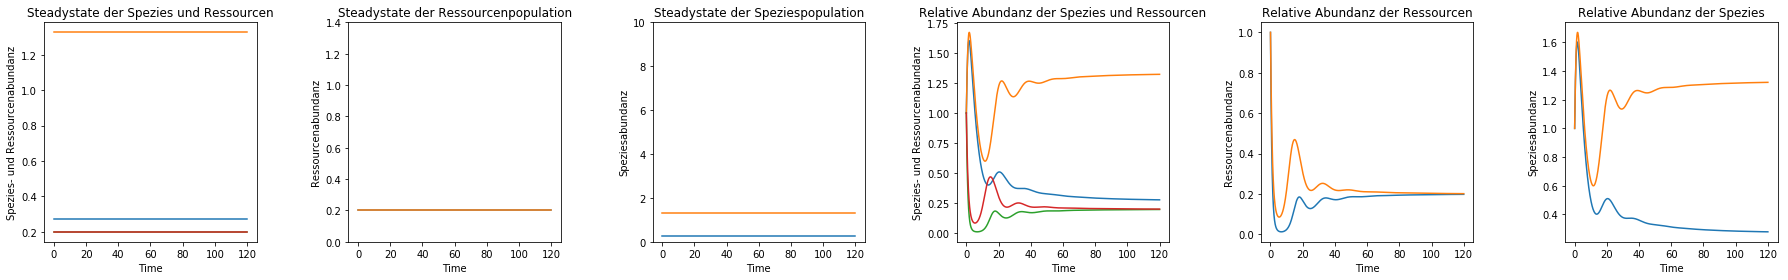

2
[[0.64261496 0.35738504]
 [0.59900197 0.40099803]]
Steadystate für R: [0.07775 0.38261] 
Steadystate für X: [0.      1.53964]


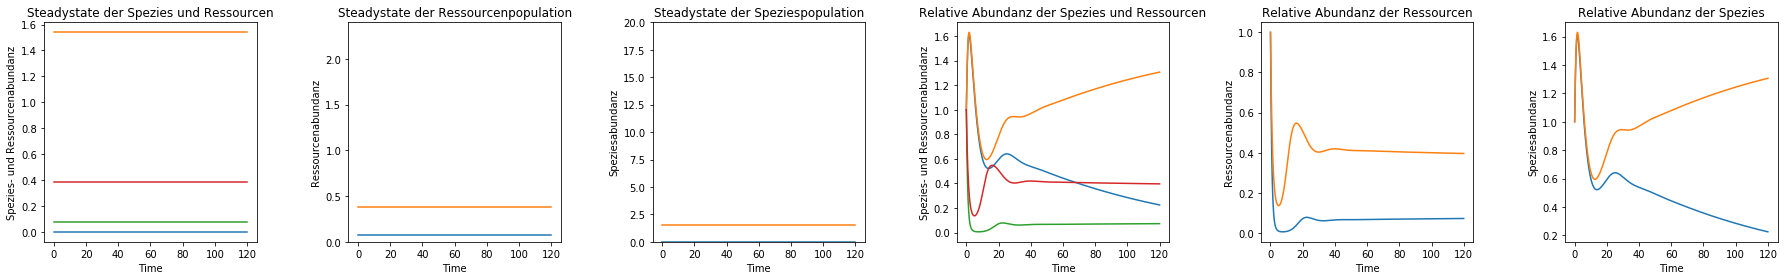

3
[[0.41921468 0.58078532]
 [0.41947947 0.58052053]]
Steadystate für R: [0.3458  0.09465] 
Steadystate für X: [1.00000e-05 1.55954e+00]


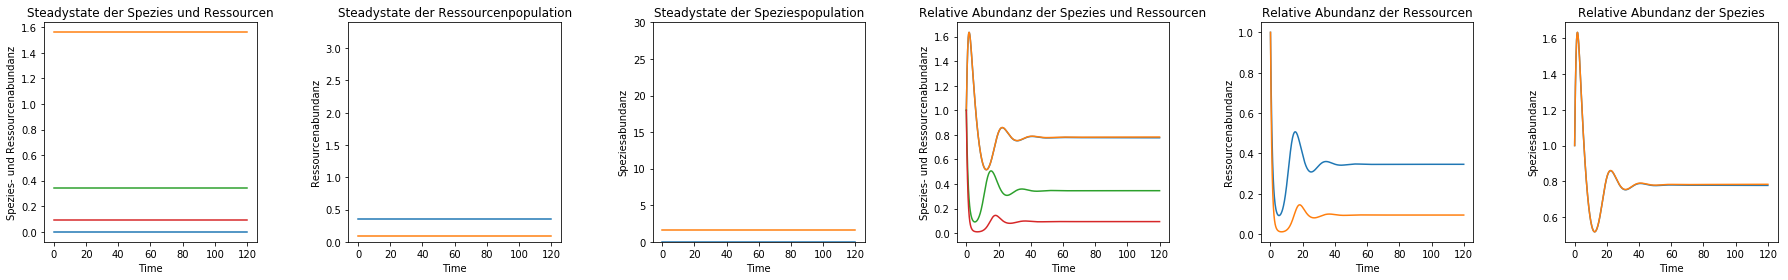

4
[[0.40371805 0.59628195]
 [0.90586987 0.09413013]]
Steadystate für R: [0.2 0.2] 
Steadystate für X: [1.29322 0.30678]


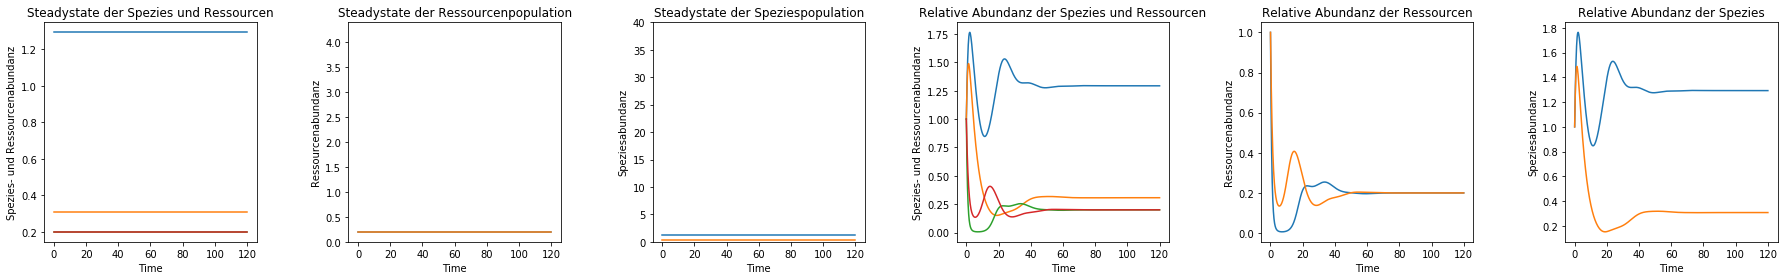

5
[[0.65863766 0.34136234]
 [0.91191293 0.08808707]]
Steadystate für R: [0.04256 0.50377] 
Steadystate für X: [1.45367 0.     ]


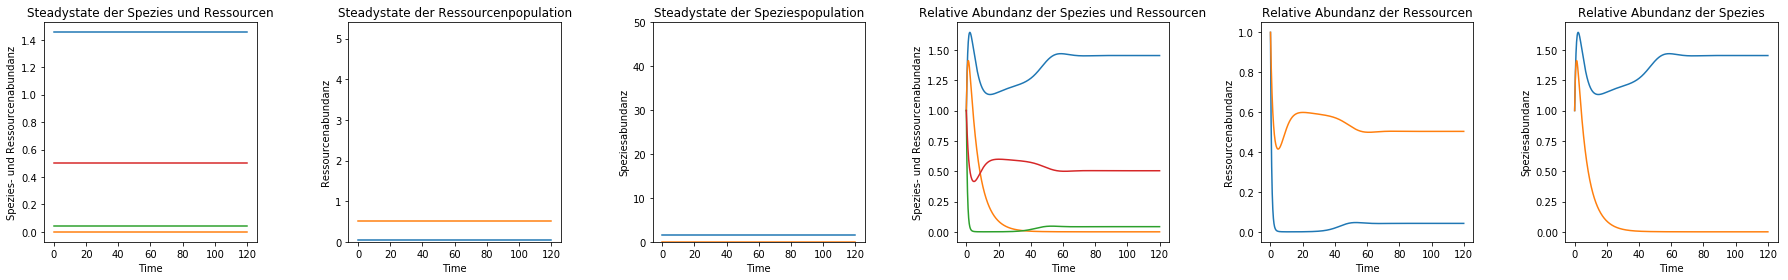

In [16]:

def h(R):
    h = r*R/K * (K - R)
    return h

def mcr(t,y,w,c,r,K,T,a):
    X = y[:number_species]
    R = y[number_species:]
    dXdt = c*X*(np.sum(w*a*R,axis=1) - T)
    dRdt = h(R) - (a*R).T.dot(X)
    output = np.concatenate((dXdt,dRdt),axis=None)
    return output

def timecourse(sys, y, t):
    integ = ode(sys).set_integrator('lsoda').set_initial_value(y,0)
    cnt = 1
    sol = [y]
    while cnt < len(t):
        sol.append(integ.integrate(t[cnt]))
        cnt += 1
    return np.array(sol)

def steadystate(system, x0,toleranz=1e-9):
    results0 = [x0]
    time=range(1000000000)
    error = np.linalg.norm(results0[0],ord=2)
    integrator = ode(system).set_integrator('lsoda').set_initial_value(x0,0)
    cnt=1
    while cnt < len(time) and error > toleranz and integrator.successful:
        zahl = integrator.integrate(time[cnt])
        error=np.linalg.norm(zahl-results0[-1],ord=2)
        results0.append(zahl) 
        cnt += 1
    return np.round(results0[-1],decimals=5)


def R_steadystate(T,w,a):
    R = (T / ((w * a).T)).T
    return R

def X_steadystate(r,a,T,w,K):
    X = ((r/a).T * (1 - (T / (w * a * K).T))).T
    return X

for i in range (1, 6):

    print(i)

    a = np.random.rand(number_species, number_resources)
    a = a/a.sum(axis=1,keepdims=1)
    print(a)   
    
    R0 = np.repeat(1,number_resources)
    X0 = np.repeat(1,number_species)
    y0 = np.concatenate((X0,R0),axis=None)
    t = np.linspace(0,120,1000)

    system = partial(mcr, w=w, c=c, r=r, K=K, T=T, a=a)
   
    
    sol0 = timecourse(system, y0, t)
    sol1 = steadystate(system, y0)
    sol2 = timecourse(system, sol1, t)
    
    if number_species == 1 and number_resources == 1:
        #RS = partial(R_steadystate,T=T, w=w, a=a)
        print("Steadystate für R:",R_steadystate(T,w,a))
        #XS = partial(X_steadystate, r=r, a=a, T=T, w=w, K=K)
        print("Steadystate für X:",X_steadystate(r,a,T,w,K))

    else:
        print("Steadystate für R:",sol1[number_species:], "\nSteadystate für X:", sol1[:number_species])  
    
    graphengroesse = (25, 4)

    fig, axes = plt.subplots(nrows=1, ncols=6, figsize=graphengroesse)
    
    #plt.suptitle('Wenn man keine Parameter ändert') 
    #plt.suptitle('Wenn man den Parameter w verdoppelt') 
    #plt.title("Test")
    axes[0].plot(t,sol2)
    axes[1].plot(t,sol2[:,number_species:])
    axes[1].set_ylim(0, i + 0.4)
    axes[2].plot(t,sol2[:,:number_species])
    axes[2].set_ylim(0, i * 10)  #sol1[:number_species][1]

    axes[3].plot(t,sol0)
    axes[4].plot(t,sol0[:,number_species:])
    #axes[4].set_ylim(0, i + 0.4)
    axes[5].plot(t,sol0[:,:number_species])
    #axes[5].set_ylim(0, i * 10)    
    

    axes[0].set_title("Steadystate der Spezies und Ressourcen")
    axes[0].set(xlabel='Time', ylabel='Spezies- und Ressourcenabundanz')
    
    axes[1].set_title("Steadystate der Ressourcenpopulation")
    axes[1].set(xlabel='Time', ylabel='Ressourcenabundanz')
    
    axes[2].set_title("Steadystate der Speziespopulation")
    axes[2].set(xlabel="Time", ylabel="Speziesabundanz")
    
    axes[3].set_title("Relative Abundanz der Spezies und Ressourcen")
    axes[3].set(xlabel='Time', ylabel='Spezies- und Ressourcenabundanz')
    
    axes[4].set_title("Relative Abundanz der Ressourcen")
    axes[4].set(xlabel='Time', ylabel='Ressourcenabundanz')
    
    axes[5].set_title("Relative Abundanz der Spezies")
    axes[5].set(xlabel="Time", ylabel="Speziesabundanz")
    fig.tight_layout()
   
    #plt.savefig(f'C:/Users/Baklava/Desktop/Ergebnisse für BA/Matrix a ist fest, Parameter ändern sich/2 Spezies, 2 Ressourcen/c geändert/mal 1000/Steadystate für R {sol1[number_species:]}, Steadystate für X {sol1[:number_species]}.png', dpi=300, bbox_inches='tight')
    plt.show()



In [55]:
for i in RS_und_XS_2:
    print("Steadystate von R:",i[0]," und Steadystate von X:",i[1])

Steadystate von R: [[0.2]]  und Steadystate von X: [[0.8]]
Steadystate von R: [[0.2]]  und Steadystate von X: [[0.8]]
Steadystate von R: [[0.2]]  und Steadystate von X: [[0.8]]
Steadystate von R: [[0.2]]  und Steadystate von X: [[0.8]]
Steadystate von R: [[0.2]]  und Steadystate von X: [[0.8]]


## Aufgabe 3.3:
Invasion in Abhängigkeit zur a-Matrix soll überprüft werden (wieviele sind gestorben, wieviele haben überlebt)